# Analyze RT barcodes in merged 37_30 analysis run

## Library import

In [1]:
## The following code ensures that all functions and init files are reloaded before executions.
%load_ext autoreload
%autoreload 2

In [2]:
%gui qt

In [4]:
## Import the custom library
import os
import sys
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import xdbit_funcs as db

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import json
import seaborn as sns
from tqdm import tqdm
import pandas as pd
import scanpy as sc

import anndata

In [6]:
def well2ind(well):
    """Convert well positions to (zero-based) indices"""
    d = {'A':0,'B':1,'C':2,'D':3,'E':4,'F':5,'G':6,'H':7}
    row = d[well[0]]
    col = int(well[1:])-1
    return [row,col]

def make_plate_overview(well_count):
    # bring the counts per well into a plate layout
    out = np.zeros([8, 12])
    for wellpos in well_count.items():
        xy = well2ind(wellpos[0])
        out[xy[0], xy[1]] = int(wellpos[1])
    return out

In [7]:
#merged_dir = r"N:\01 HPC\03 Team Meier\10_Resources\08_Johannes Wirth\Nextcloud\DbitX\data\37_30\matrices_merged"
#wells_dir = r"N:\01 HPC\03 Team Meier\10_Resources\08_Johannes Wirth\Nextcloud\DbitX\data\37_30\matrices\allRT"
wells_dir = r"Z:\Daten\01 HPC\03 Team Meier\08_Projects\37_Spatial_Barcoding\37_30\data\matrices\allRT"

In [8]:
well_names = [d for d in os.listdir(wells_dir) if os.path.isdir(os.path.join(wells_dir, d))]
well_dirs = [os.path.join(wells_dir, d) for d in os.listdir(wells_dir) if os.path.isdir(os.path.join(wells_dir, d))]

In [9]:
well_names

['A1', 'A2', 'A3', 'B1', 'B3', 'C1', 'C2', 'C3']

In [10]:
well_dirs

['Z:\\Daten\\01 HPC\\03 Team Meier\\08_Projects\\37_Spatial_Barcoding\\37_30\\data\\matrices\\allRT\\A1',
 'Z:\\Daten\\01 HPC\\03 Team Meier\\08_Projects\\37_Spatial_Barcoding\\37_30\\data\\matrices\\allRT\\A2',
 'Z:\\Daten\\01 HPC\\03 Team Meier\\08_Projects\\37_Spatial_Barcoding\\37_30\\data\\matrices\\allRT\\A3',
 'Z:\\Daten\\01 HPC\\03 Team Meier\\08_Projects\\37_Spatial_Barcoding\\37_30\\data\\matrices\\allRT\\B1',
 'Z:\\Daten\\01 HPC\\03 Team Meier\\08_Projects\\37_Spatial_Barcoding\\37_30\\data\\matrices\\allRT\\B3',
 'Z:\\Daten\\01 HPC\\03 Team Meier\\08_Projects\\37_Spatial_Barcoding\\37_30\\data\\matrices\\allRT\\C1',
 'Z:\\Daten\\01 HPC\\03 Team Meier\\08_Projects\\37_Spatial_Barcoding\\37_30\\data\\matrices\\allRT\\C2',
 'Z:\\Daten\\01 HPC\\03 Team Meier\\08_Projects\\37_Spatial_Barcoding\\37_30\\data\\matrices\\allRT\\C3']

In [11]:
stats_merged = json.load(open(os.path.join(merged_dir, "recording_dictionary.json")))

NameError: name 'merged_dir' is not defined

In [12]:
stats_wells = {name: json.load(open(os.path.join(d, "recording_dictionary.json"))) for name, d in zip(well_names, well_dirs)}

In [13]:
mtx = make_plate_overview(stats_wells['A1']['Z']['well_counts'])

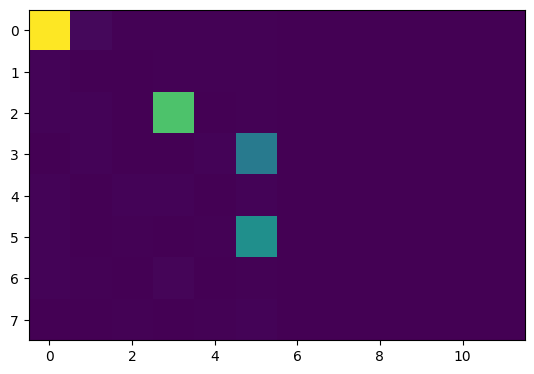

In [14]:
plt.imshow(mtx)

## Introduction

There are two possible ways to do the well barcoding:
1. Barcoding on RT primer level after combined lysis of the sections
2. Barcoding on indexing PCR level after separate lysis of the sections

### Question 1

One question that we have to answer here is whether there is any mixing occuring between the wells during lysis or during the channel barcoding steps before. In order to analyze this I barcoded in 37_30 the wells on both the RT primer level and the indexing PCR level and ran the analysis pipeline in three different ways:

1. Analysis of each well separately using only the expected RT primer barcodes for each well (optimal pipeline for setup with indexing primer barcoding).
2. Analysis of each well separately using the RT primer barcodes of all 9 wells together.
3. Merging of all fastq files and analysis of the merged fastq (pipeline which is necessary if barcoding on RT level and using combined lysis).

### Question 2
A second question that needs to be answered is how the read and gene depths changes depending on the two barcoding setups.

## Question 1: Are wrong Z variables assigned to some of the adata sets?

In [ ]:
adatas = [sc.read_text(os.path.join(d, "DGE_matrix_with_introns_min100.txt.gz")).transpose() for d in well_dirs]

In [15]:
# convert coordinates into µm
resolution = 50 #µm

for adata in adatas:
    # add coordinates to adata object
    adata.obs['array_row'] = np.array([int(elem.split('x')[1]) for elem in adata.obs_names])
    adata.obs['array_col'] = np.array([int(elem.split('x')[0]) for elem in adata.obs_names])
    adata.obs['well'] = np.array([str(elem.split('x')[2]) for elem in adata.obs_names])

    adata.obs['um_row'] = np.array([db.calc.coord_to_um(c, resolution) for c in adata.obs['array_row']])
    adata.obs['um_col'] = np.array([db.calc.coord_to_um(c, resolution) for c in adata.obs['array_col']])

### Calculate qc metrics

In [16]:
for adata in adatas:
    adata.var['mt'] = adata.var_names.str.contains('MT-', case=False)  # annotate the group of mitochondrial genes as 'mt'

    sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

### Calculate 18S percentage per spot

In [17]:
for adata in adatas:
    # calculate 18S percentage
    ribo_idx = adata.var.index.get_loc('CT010467.1')
    ribo_counts = adata.X[:, ribo_idx]
    adata.obs['18S_pct'] = ribo_counts / adata.obs.total_counts * 100

## Filtering

In [21]:
for adata in adatas:
    sc.pp.filter_cells(adata, min_counts=2500)
    sc.pp.filter_cells(adata, max_counts=50000)
    adata = adata[adata.obs["pct_counts_mt"] < 15]
    adata = adata[adata.obs["18S_pct"] < 50]
    sc.pp.filter_genes(adata, min_cells=10)

D:\Users\johannes.wirth\Anaconda3\envs\spatial\lib\site-packages\pandas\core\arrays\categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
D:\Users\johannes.wirth\Anaconda3\envs\spatial\lib\site-packages\pandas\core\arrays\categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
D:\Users\johannes.wirth\Anaconda3\envs\spatial\lib\site-packages\pandas\core\arrays\categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
Trying to set attribute `.var` of view, copying.
D:\Users\johannes.wirth\Anaconda3\envs\spatial\lib\site-packages\pandas\core\arrays\categorical.py:2487: FutureWarnin

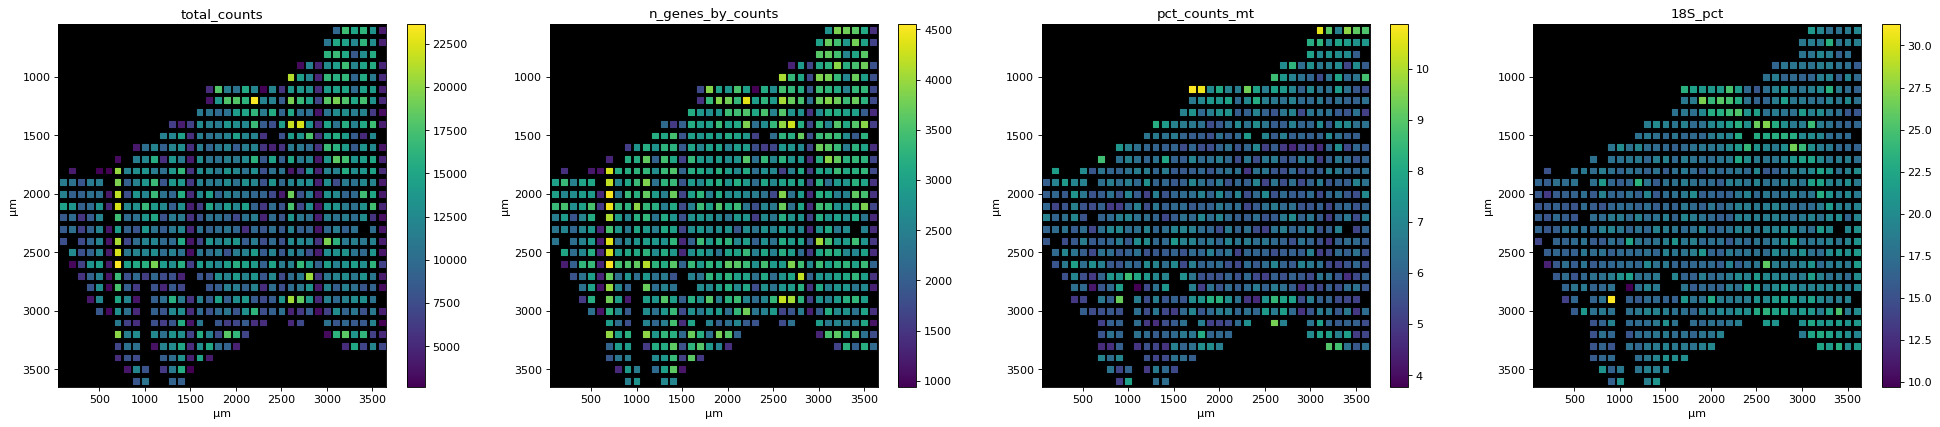

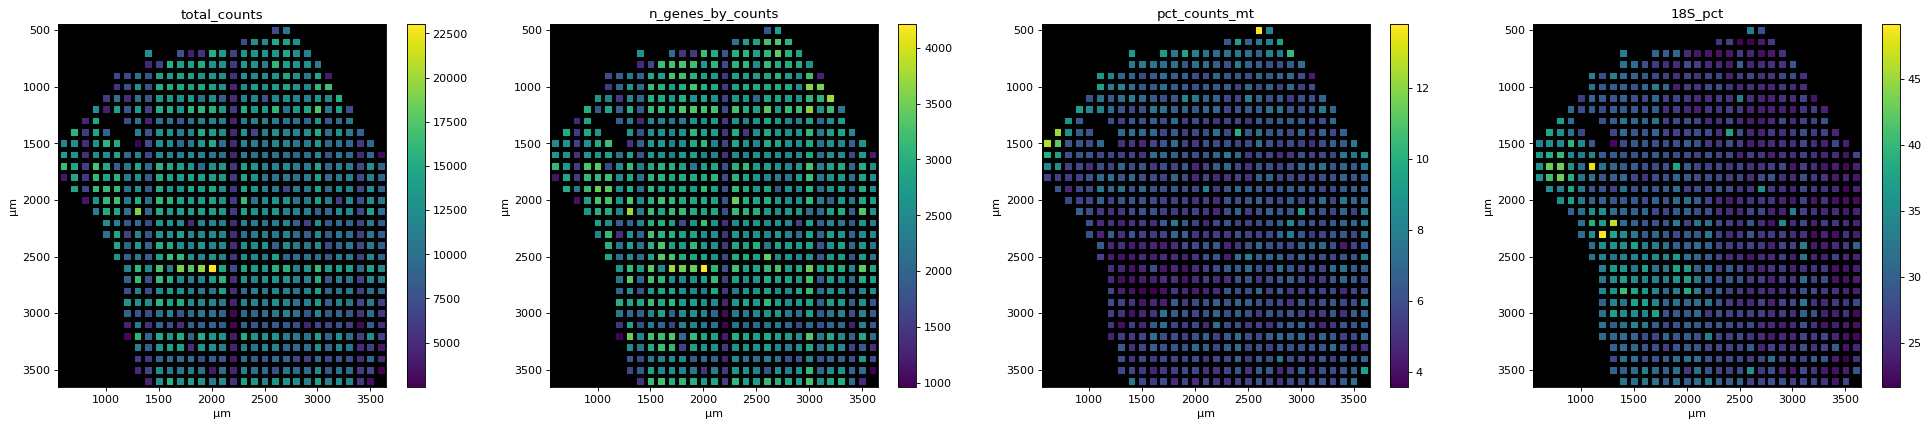

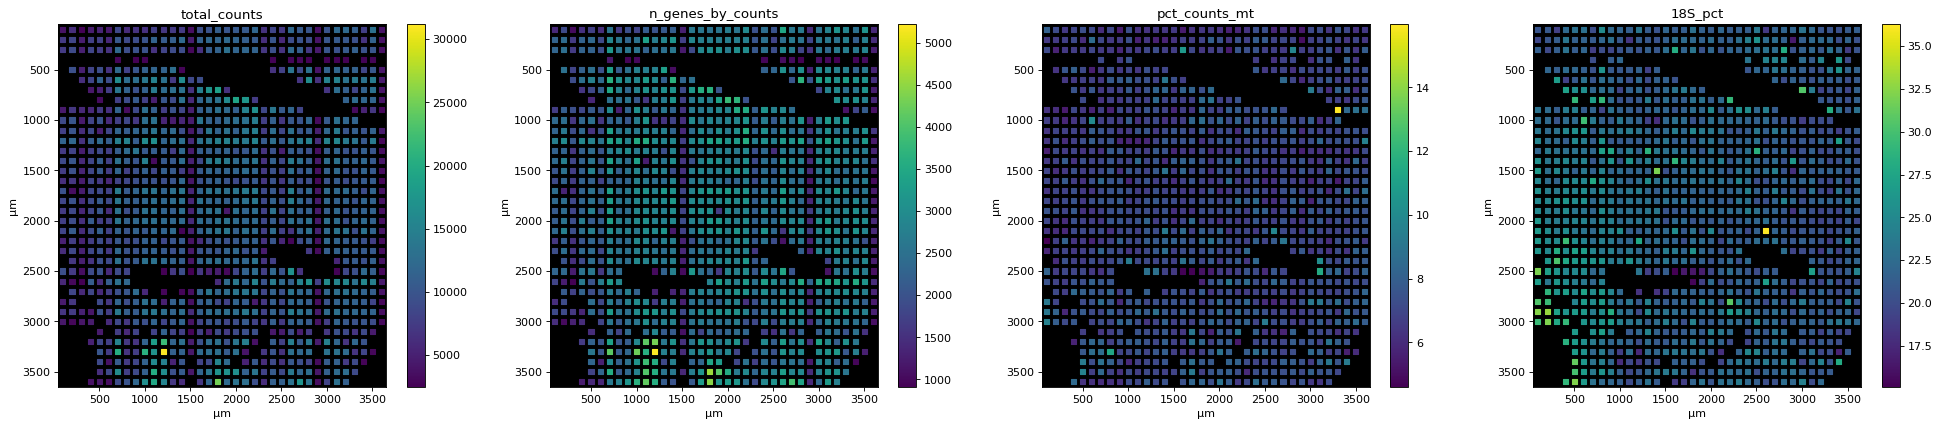

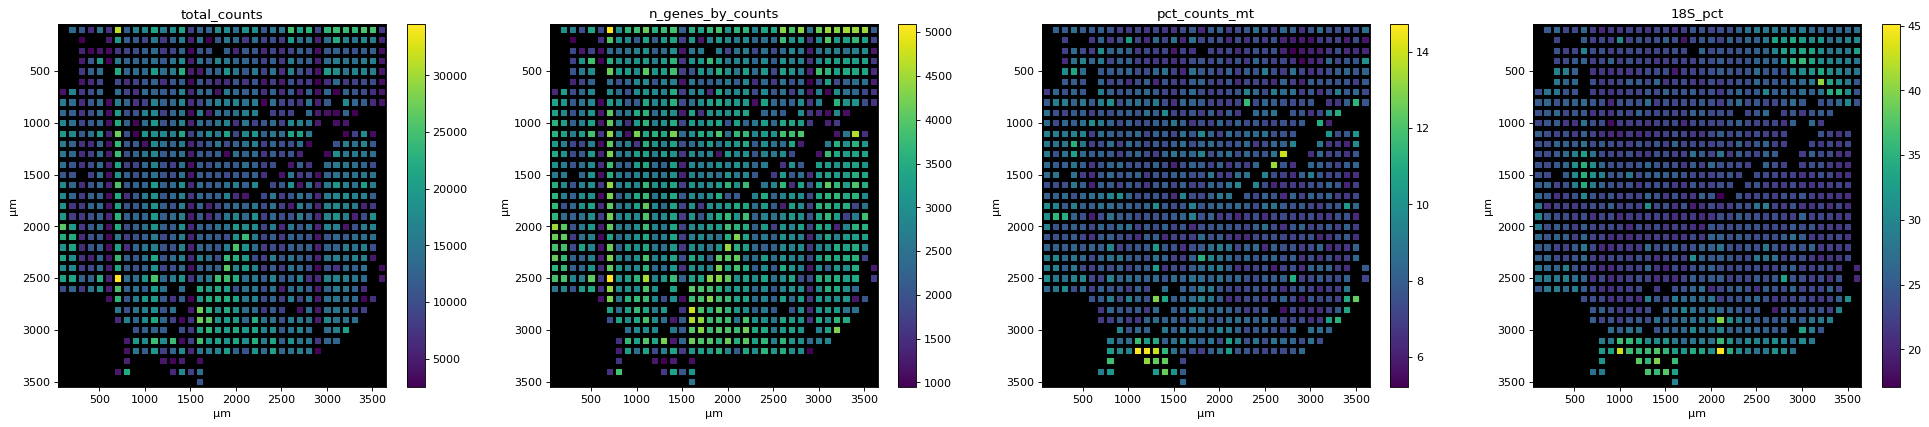

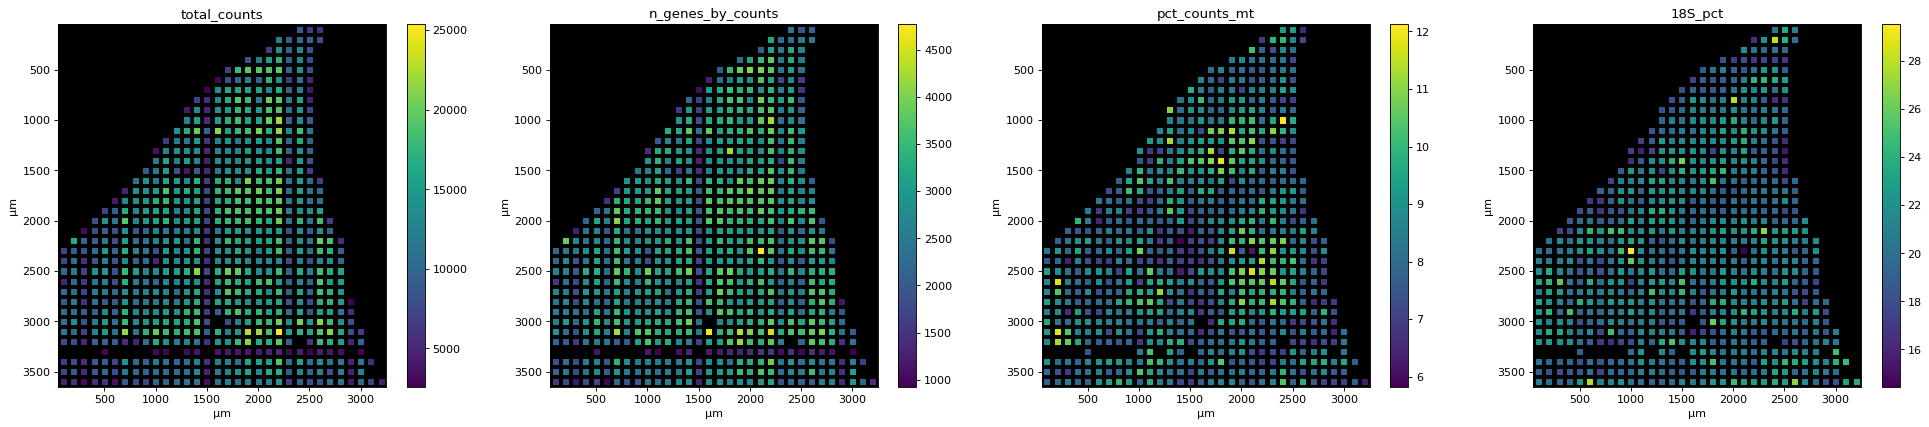

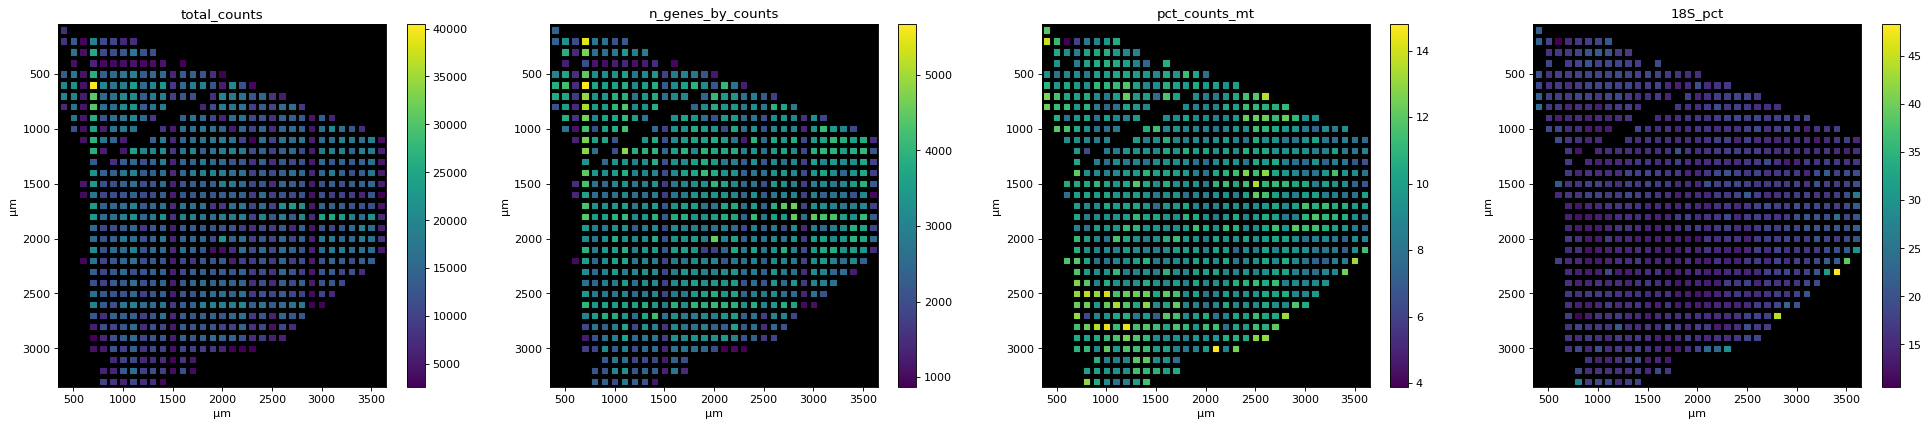

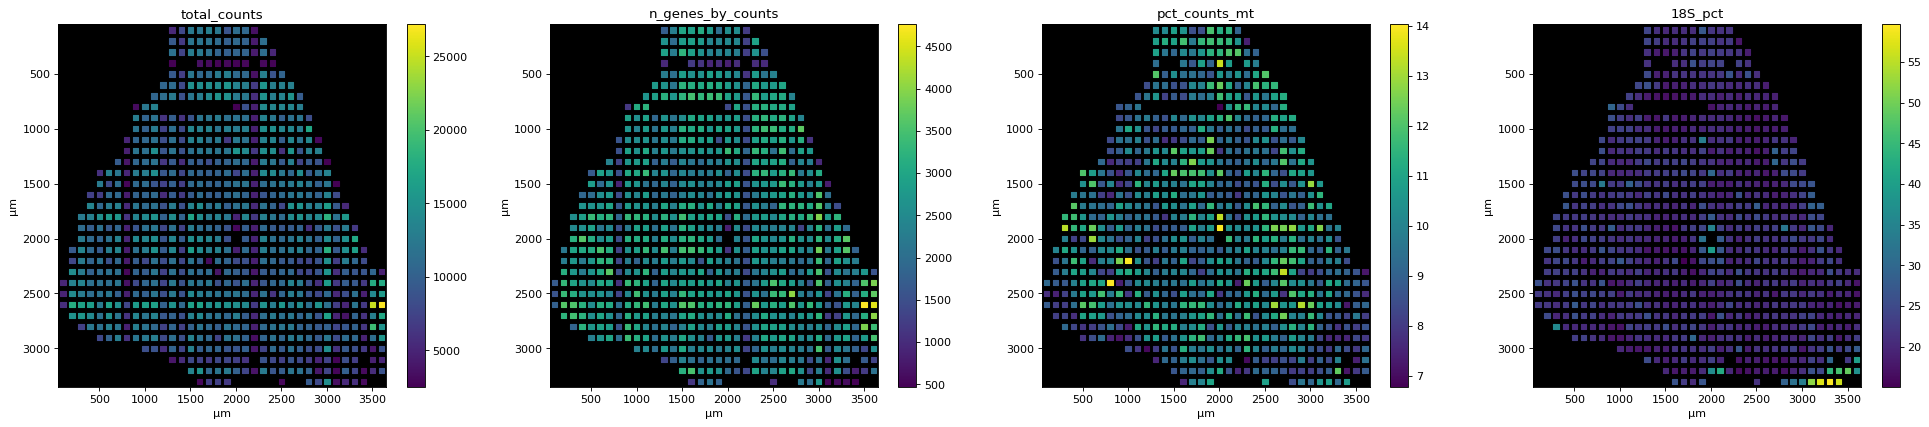

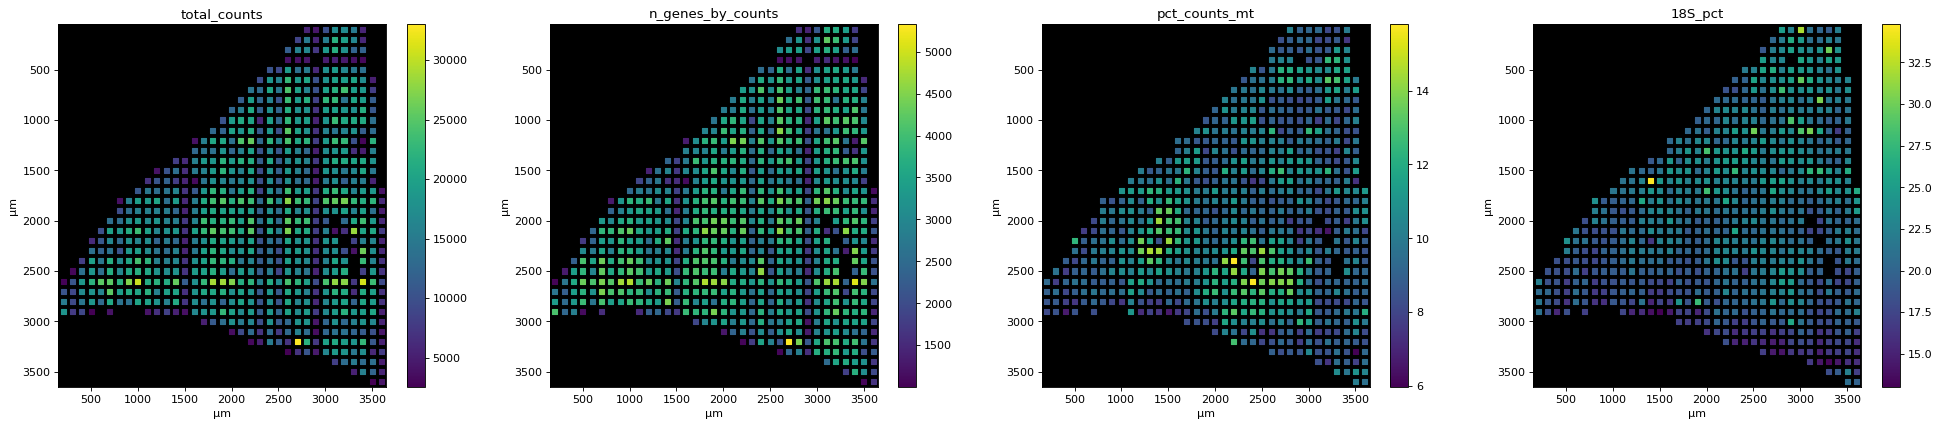

In [22]:
for adata in adatas:
    db.pl.spatial(adata, ['total_counts', 'n_genes_by_counts', 'pct_counts_mt', '18S_pct'], pd_dataframe=adata.obs)

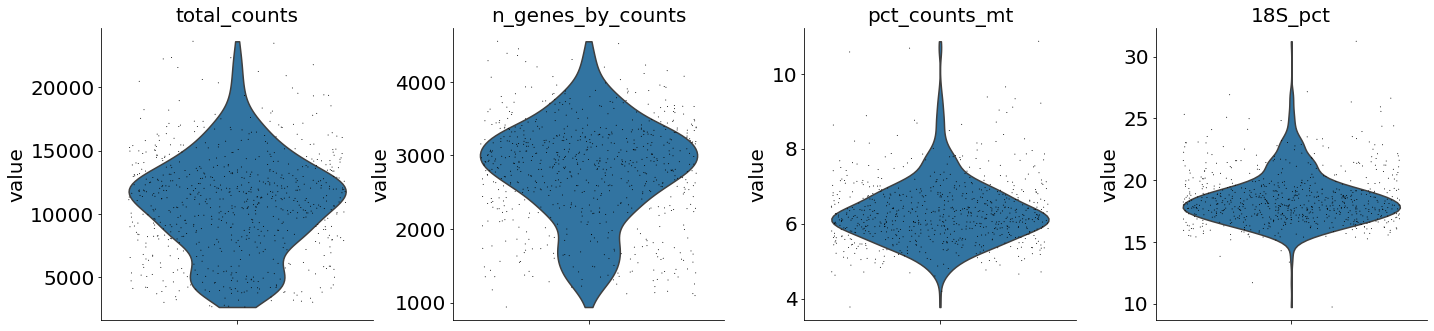

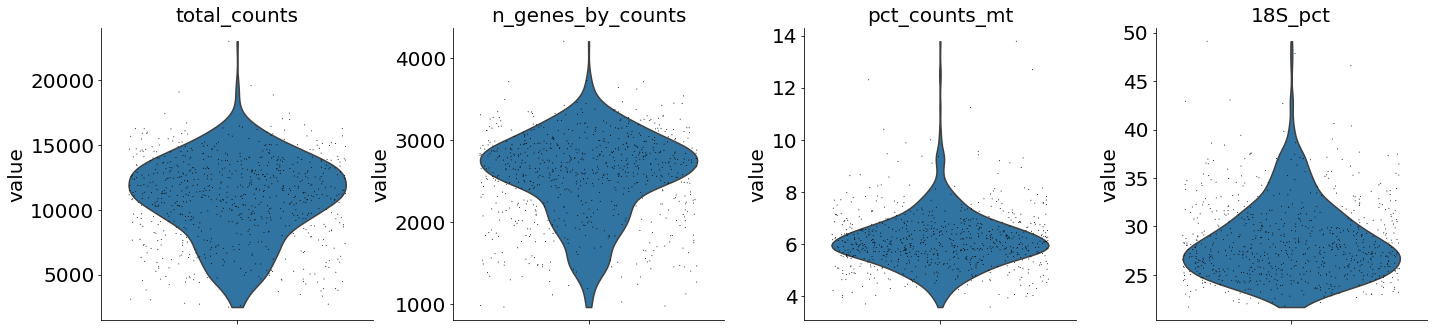

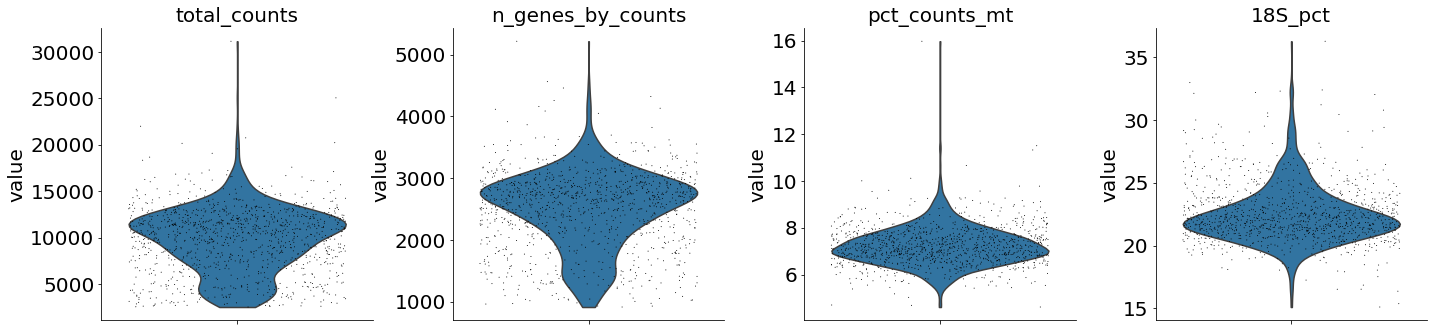

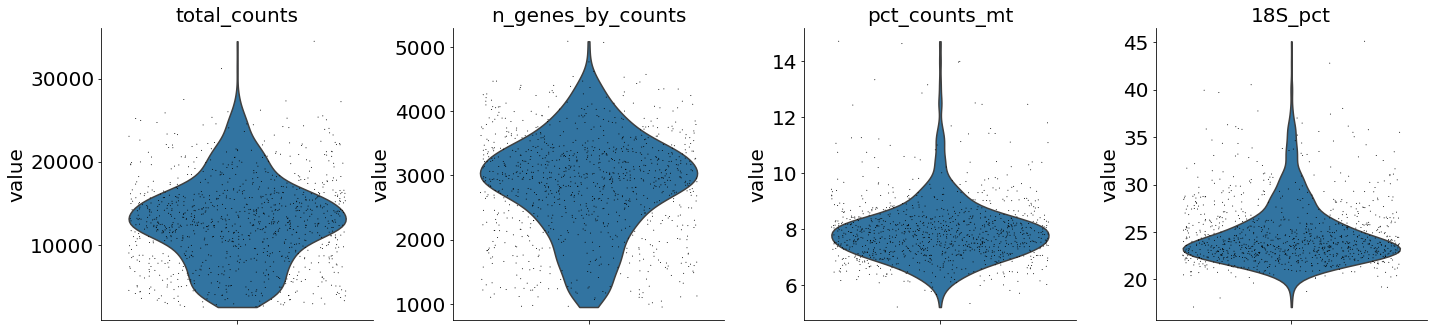

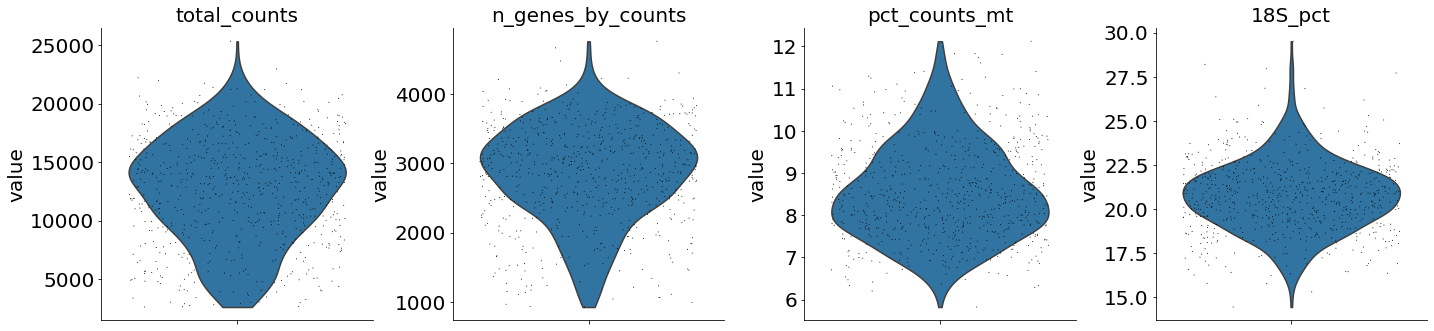

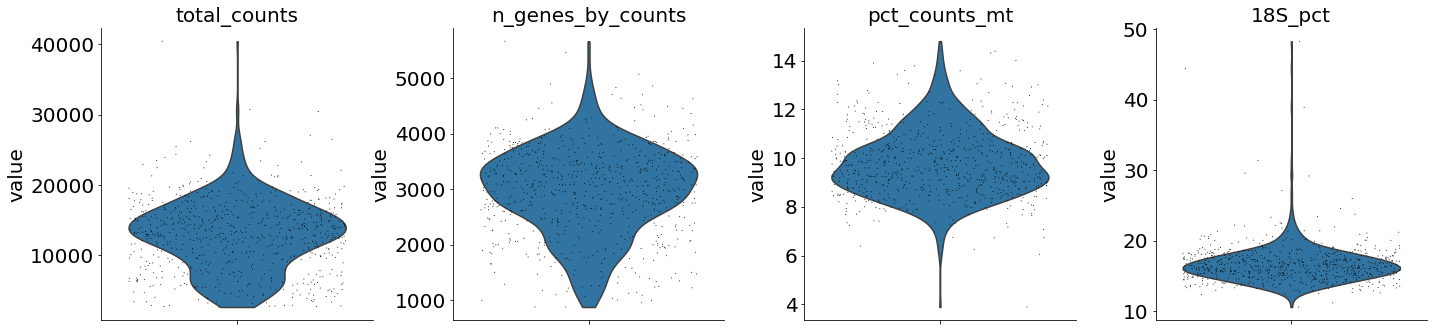

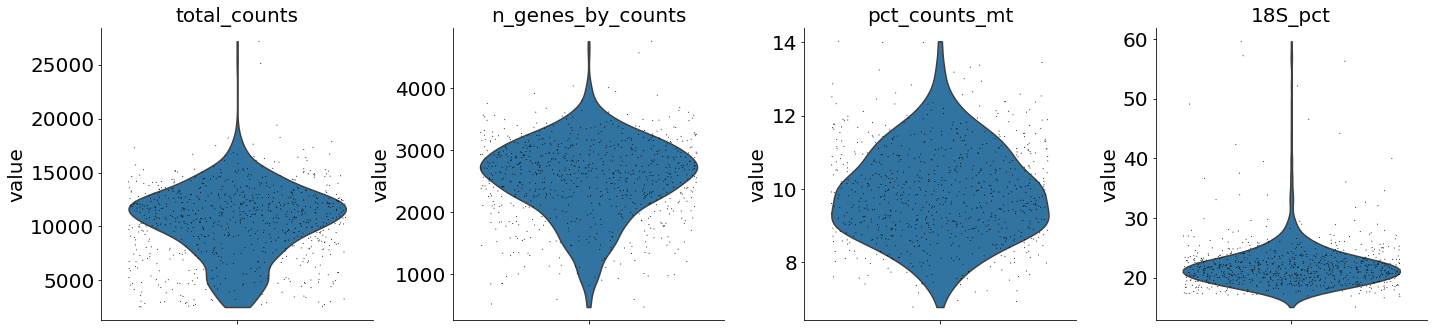

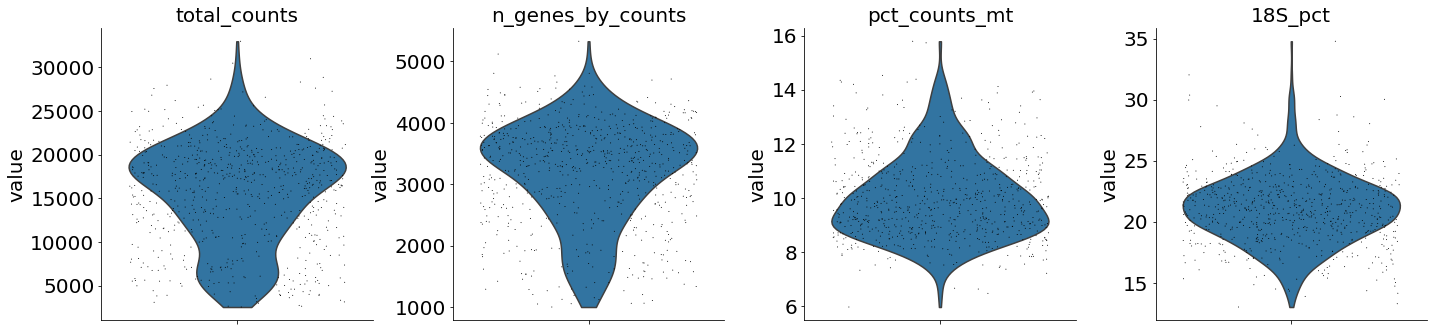

In [23]:
for adata in adatas:
    with plt.rc_context({'font.size': 20}):
        sc.pl.violin(adata, ['total_counts', 'n_genes_by_counts', 'pct_counts_mt', '18S_pct'], jitter=0.4, multi_panel=True)

In [54]:
df = pd.DataFrame(columns=cats, index=cats)

cats = ['0', '1', '2', '3', '5', '6', '7', '8']

for i, col in enumerate(cats):
    for row in cats:
        perc = (adatas[i].obs.well == row).sum() / len(adatas[i])
        df.loc[row, col] = perc

array([<AxesSubplot:ylabel='0'>, <AxesSubplot:ylabel='1'>,
       <AxesSubplot:ylabel='2'>, <AxesSubplot:ylabel='3'>,
       <AxesSubplot:ylabel='5'>, <AxesSubplot:ylabel='6'>,
       <AxesSubplot:ylabel='7'>, <AxesSubplot:ylabel='8'>], dtype=object)

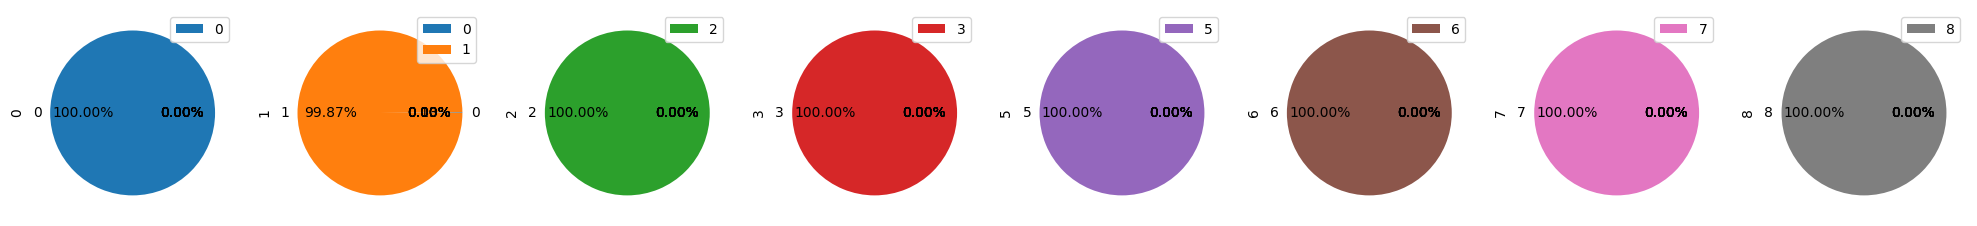

In [98]:
df.plot.pie(subplots=True, autopct="%.2f%%", figsize=(25,10), legend=True)

### Answer to Question 1:

There is no mixture between the different wells. Only in well '1' I found one spot from well '0' that would not have been filtered out.

## Question 2: How does the read and gene depth change depending on the different barcoding strategies?

Strategy: Load merged adata and adata from analysis with separated wells and RT primers specific for each well


In [101]:
adata_merged = sc.read_text(os.path.join(merged_dir, "DGE_matrix_with_introns_min100.txt.gz")).transpose()

In [103]:
# convert coordinates into µm
resolution = 50 #µm

for adata in [adata_merged]:
    # add coordinates to adata object
    adata.obs['array_row'] = np.array([int(elem.split('x')[1]) for elem in adata.obs_names])
    adata.obs['array_col'] = np.array([int(elem.split('x')[0]) for elem in adata.obs_names])
    adata.obs['well'] = np.array([str(elem.split('x')[2]) for elem in adata.obs_names])

    adata.obs['um_row'] = np.array([db.calc.coord_to_um(c, resolution) for c in adata.obs['array_row']])
    adata.obs['um_col'] = np.array([db.calc.coord_to_um(c, resolution) for c in adata.obs['array_col']])

In [129]:
adata_merged.obs['pipeline'] = 'merged'

### Calculate qc metrics

In [104]:
for adata in [adata_merged]:
    adata.var['mt'] = adata.var_names.str.contains('MT-', case=False)  # annotate the group of mitochondrial genes as 'mt'

    sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

### Calculate 18S percentage per spot

In [109]:
for adata in [adata_merged]:
    # calculate 18S percentage
    ribo_idx = adata.var.index.get_loc('CT010467.1')
    ribo_counts = adata.X[:, ribo_idx]
    adata.obs['18S_pct'] = ribo_counts / adata.obs.total_counts * 100

## QC and preprocessing

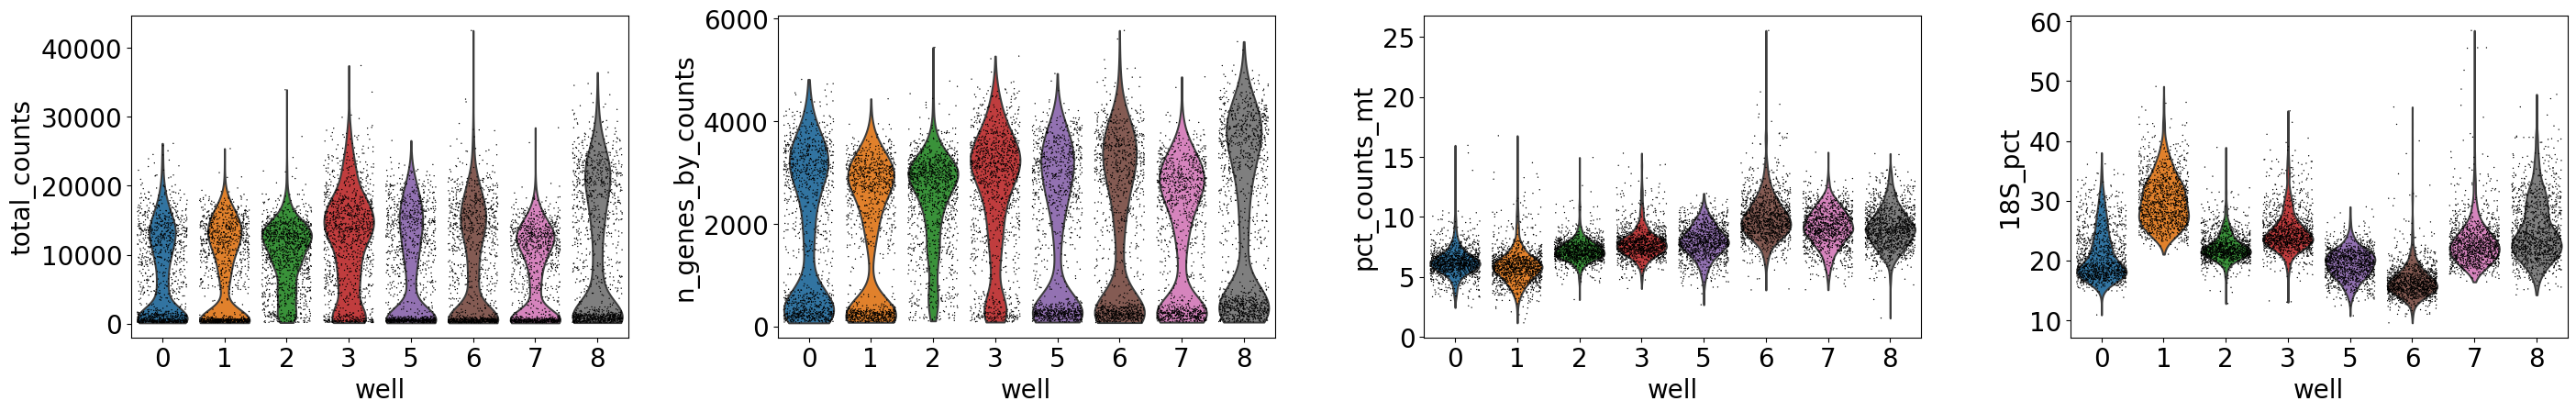

In [110]:
with plt.rc_context({'font.size': 20}):
    sc.pl.violin(adata_merged, ['total_counts', 'n_genes_by_counts', 'pct_counts_mt', '18S_pct'], jitter=0.4, multi_panel=True, groupby='well')

D:\Users\johannes.wirth\Anaconda3\envs\spatial\lib\site-packages\pandas\core\arrays\categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


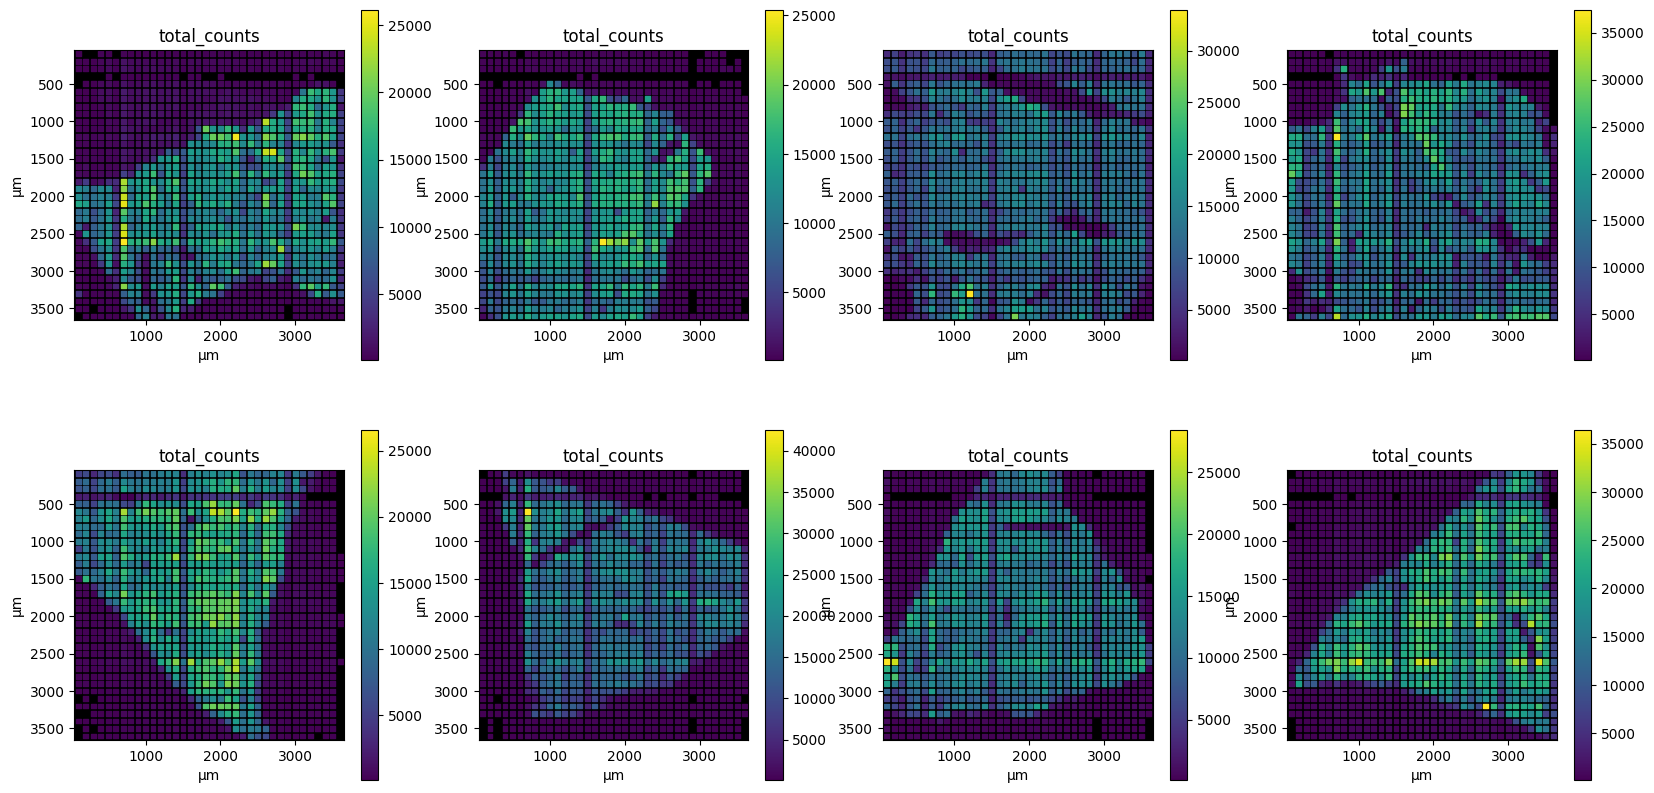

In [112]:
fig,axs = plt.subplots(2, 4, figsize=(20, 10))
axs = axs.ravel()

well_list = [int(elem) for elem in adata.obs['well'].unique()]
well_list.sort()

for idx, w in enumerate(well_list):
    axs[idx].set_aspect(1)
    db.pl.spatial(adata, ['total_counts'], groupby='well', group=str(w), axis=axs[idx], fig=fig, show=False)

## Load data from separate analysis

In [115]:
#out_dir = "/Users/Johannes/Nextcloud/DbitX/data/37_30/outs/"
out_dir = r"N:\01 HPC\03 Team Meier\10_Resources\08_Johannes Wirth\Nextcloud\DbitX\data\37_30\matrices\wells"
matrix_dirs = [os.path.join(out_dir, d) for d in os.listdir(out_dir)]

## Analyze datasets together

In [137]:
adatas_sep = [sc.read_text(os.path.join(d, "DGE_matrix_with_introns_min100.txt.gz")).transpose() for d in matrix_dirs]

In [138]:
# make obs_names unique
well_id = [0,1,2,3,5,6,7,8]

for i, adata in zip(well_id, adatas_sep):
    adata.obs_names = [elem + "x" + str(i) for elem in adata.obs_names]

In [139]:
# convert coordinates into µm
resolution = 50 #µm

for adata in adatas_sep:
    # add coordinates to adata object
    adata.obs['array_row'] = np.array([int(elem.split('x')[1]) for elem in adata.obs_names])
    adata.obs['array_col'] = np.array([int(elem.split('x')[0]) for elem in adata.obs_names])
    adata.obs['well'] = np.array([str(elem.split('x')[2]) for elem in adata.obs_names])

    adata.obs['um_row'] = np.array([db.calc.coord_to_um(c, resolution) for c in adata.obs['array_row']])
    adata.obs['um_col'] = np.array([db.calc.coord_to_um(c, resolution) for c in adata.obs['array_col']])

### Calculate qc metrics

In [143]:
for adata in adatas_sep:
    adata.var['mt'] = adata.var_names.str.contains('MT-', case=False)  # annotate the group of mitochondrial genes as 'mt'

    sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

### Calculate 18S percentage per spot

In [144]:
for adata in adatas_sep:
    # calculate 18S percentage
    ribo_idx = adata.var.index.get_loc('CT010467.1')
    ribo_counts = adata.X[:, ribo_idx]
    adata.obs['18S_pct'] = ribo_counts / adata.obs.total_counts * 100

In [145]:
adata_sep = anndata.concat(adatas_sep)

In [146]:
adata_sep.obs['pipeline'] = 'separated'

### Merge adatas of separated and merged analysis

In [147]:
adata = anndata.concat([adata_merged, adata_sep])

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


In [148]:
adata.obs.pipeline

28x21x8       merged
28x21x7       merged
28x21x0       merged
28x21x2       merged
28x21x1       merged
             ...    
18x27x8    separated
18x22x8    separated
18x21x8    separated
18x24x8    separated
18x23x8    separated
Name: pipeline, Length: 20351, dtype: object

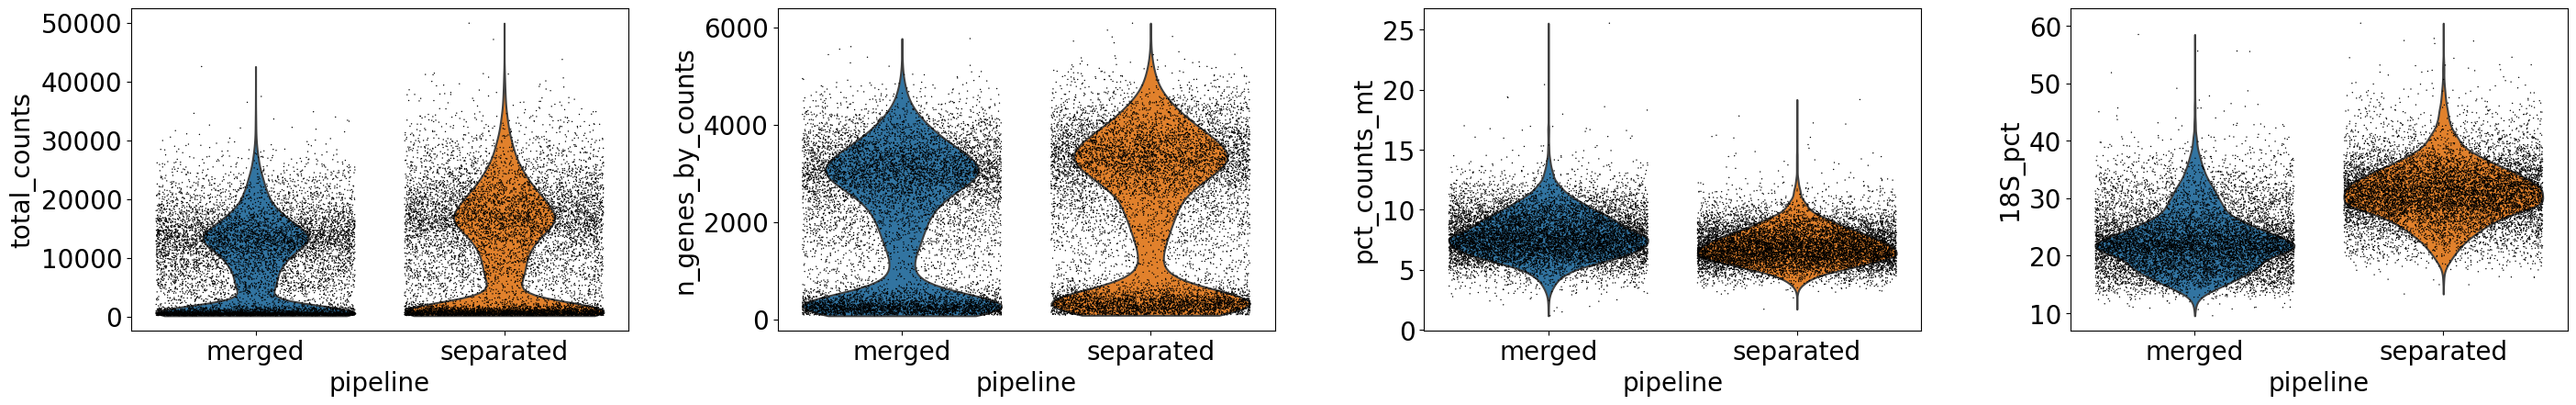

In [152]:
with plt.rc_context({'font.size': 20}):
    sc.pl.violin(adata, ['total_counts', 'n_genes_by_counts', 'pct_counts_mt', '18S_pct'], jitter=0.4, multi_panel=True, groupby='pipeline')

In [155]:
sc.pp.filter_cells(adata, min_counts=2500)
sc.pp.filter_cells(adata, max_counts=50000)
adata = adata[adata.obs["pct_counts_mt"] < 15]
adata = adata[adata.obs["18S_pct"] < 50]
sc.pp.filter_genes(adata, min_cells=10)

D:\Users\johannes.wirth\Anaconda3\envs\spatial\lib\site-packages\pandas\core\arrays\categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
D:\Users\johannes.wirth\Anaconda3\envs\spatial\lib\site-packages\pandas\core\arrays\categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
D:\Users\johannes.wirth\Anaconda3\envs\spatial\lib\site-packages\pandas\core\arrays\categorical.py:2

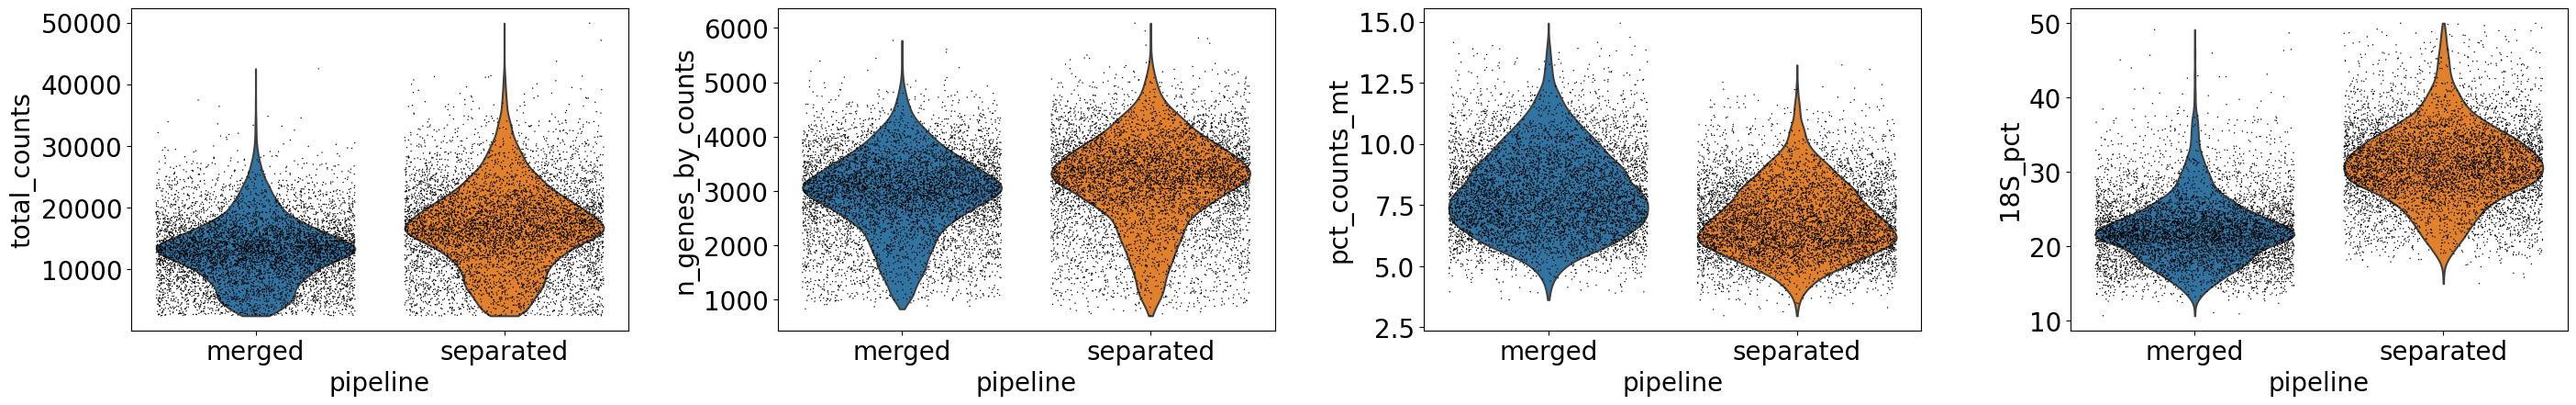

In [159]:
with plt.rc_context({'font.size': 20}):
    sc.pl.violin(adata, ['total_counts', 'n_genes_by_counts', 'pct_counts_mt', '18S_pct'], jitter=0.4, multi_panel=True, groupby='pipeline')

In [170]:
adata[adata.obs.well == '0', :]

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


AnnData object with n_obs × n_vars = 1484 × 18028
    obs: 'array_row', 'array_col', 'well', 'um_row', 'um_col', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', '18S_pct', 'pipeline', 'n_counts'
    var: 'n_cells'
    uns: 'well_colors', 'pipeline_colors'

D:\Users\johannes.wirth\Anaconda3\envs\spatial\lib\site-packages\pandas\core\arrays\categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


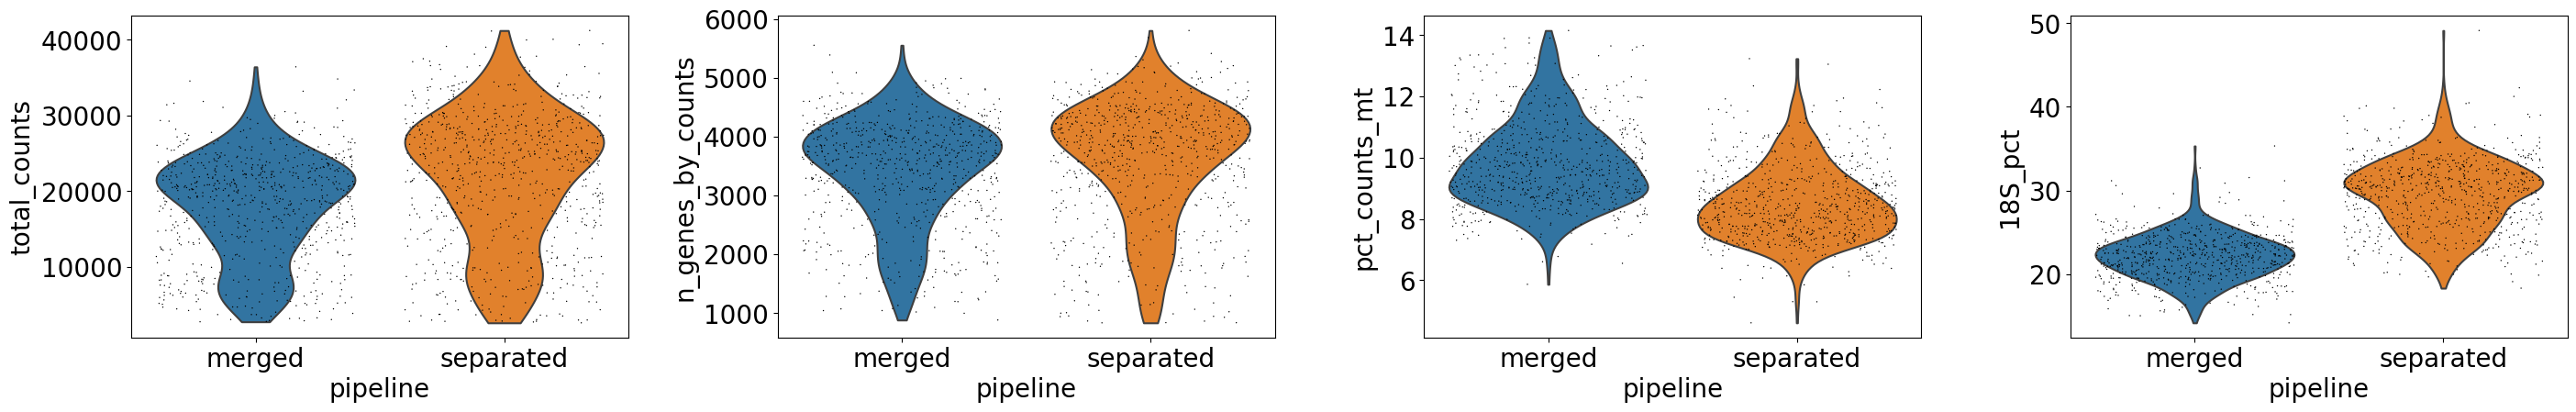

D:\Users\johannes.wirth\Anaconda3\envs\spatial\lib\site-packages\pandas\core\arrays\categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


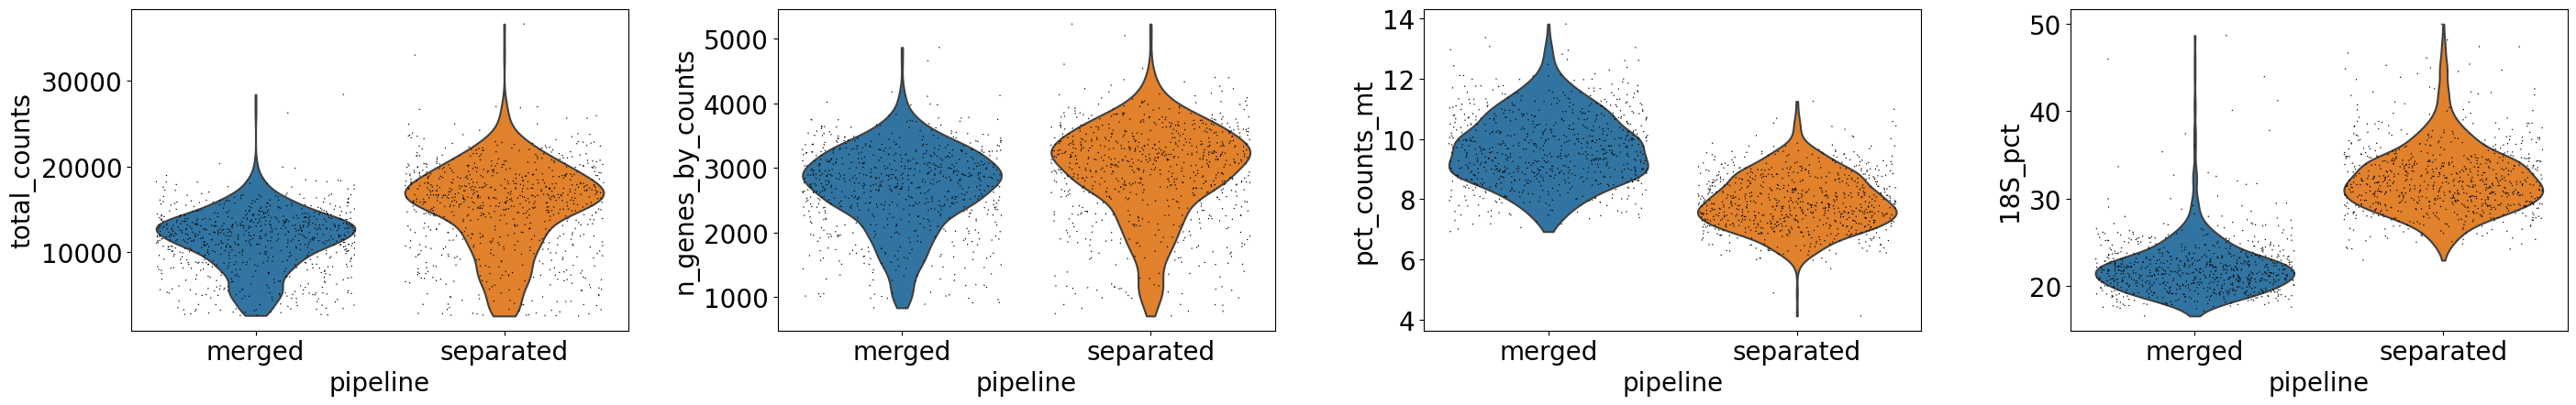

D:\Users\johannes.wirth\Anaconda3\envs\spatial\lib\site-packages\pandas\core\arrays\categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


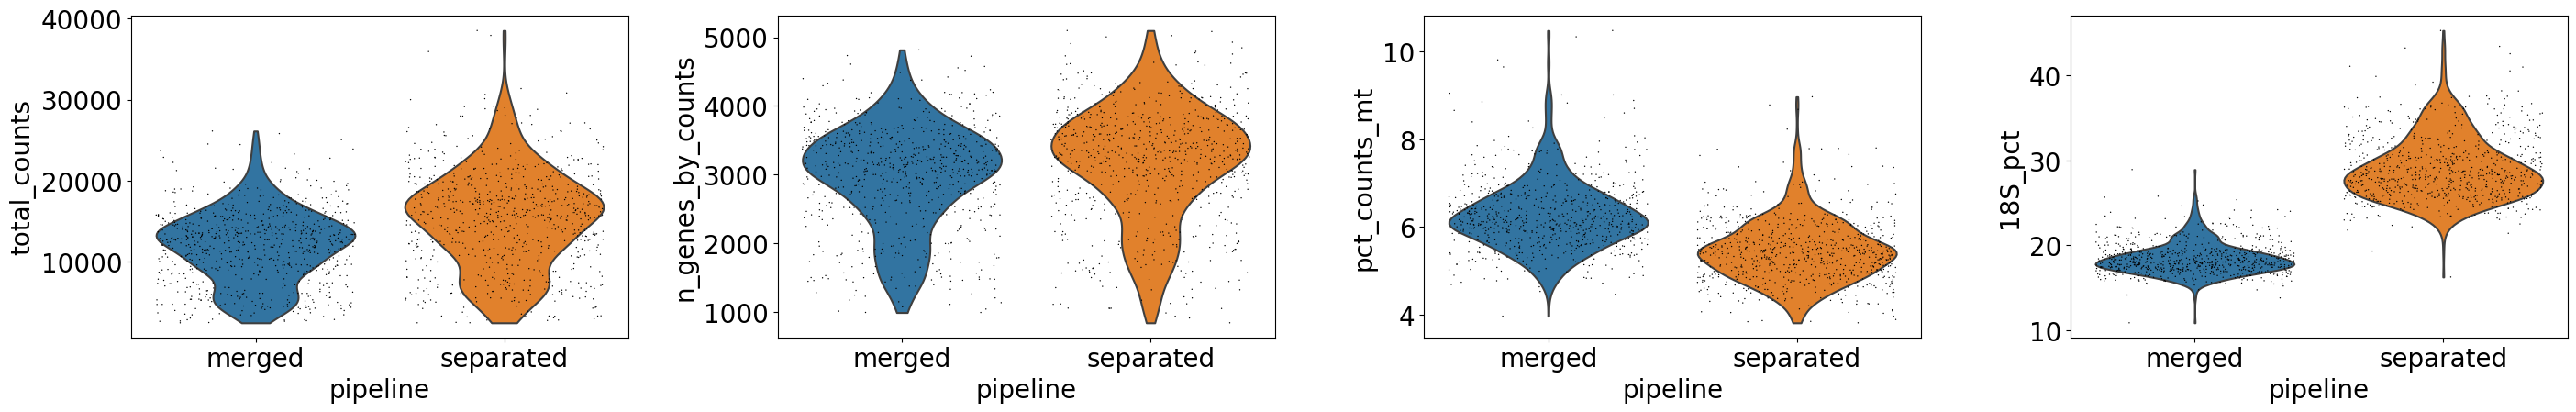

D:\Users\johannes.wirth\Anaconda3\envs\spatial\lib\site-packages\pandas\core\arrays\categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


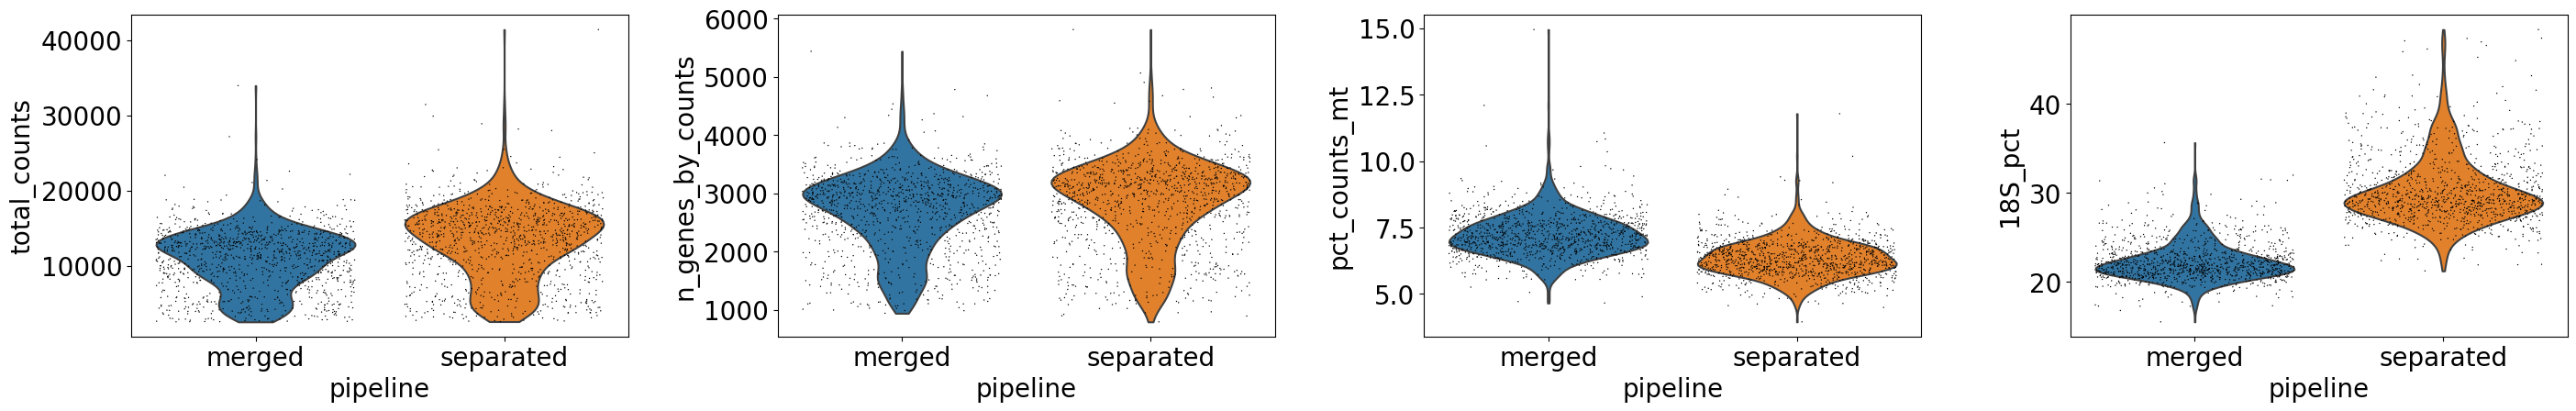

D:\Users\johannes.wirth\Anaconda3\envs\spatial\lib\site-packages\pandas\core\arrays\categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


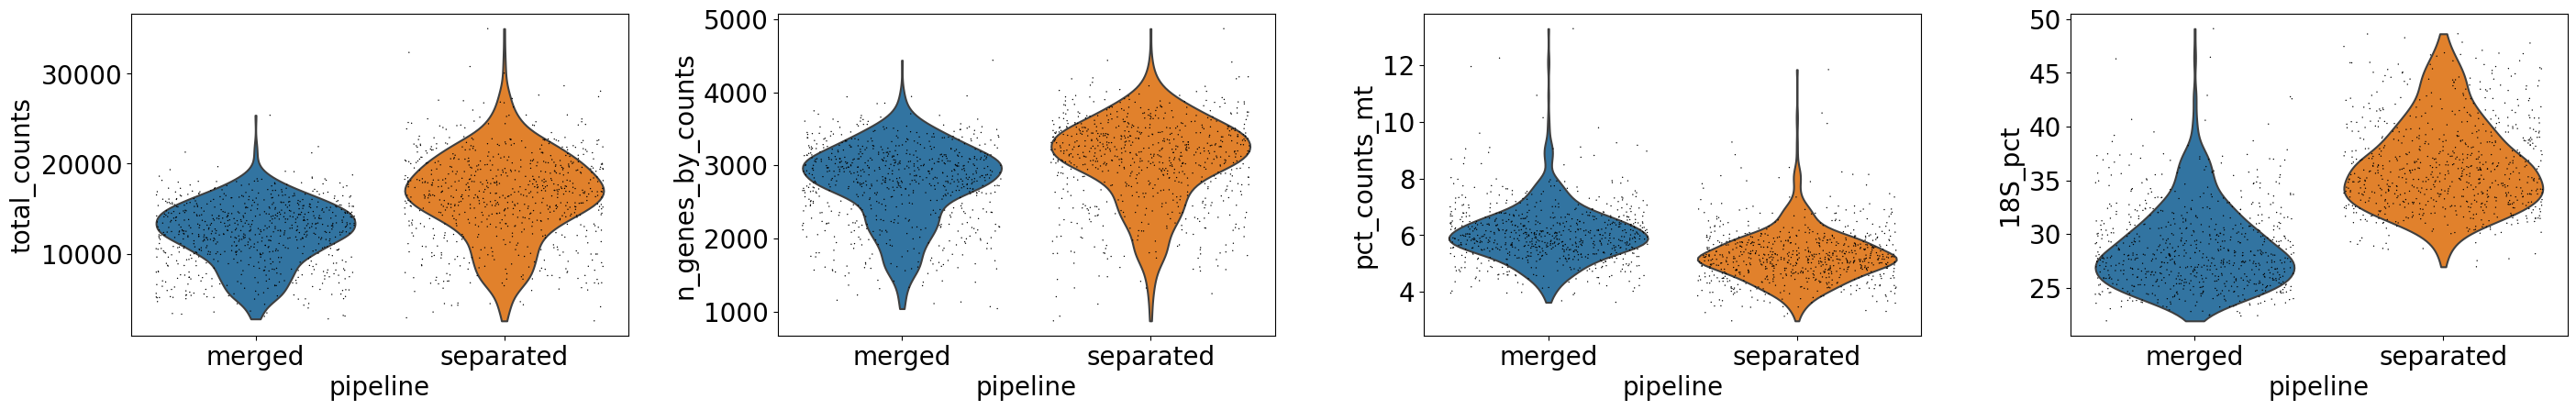

D:\Users\johannes.wirth\Anaconda3\envs\spatial\lib\site-packages\pandas\core\arrays\categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


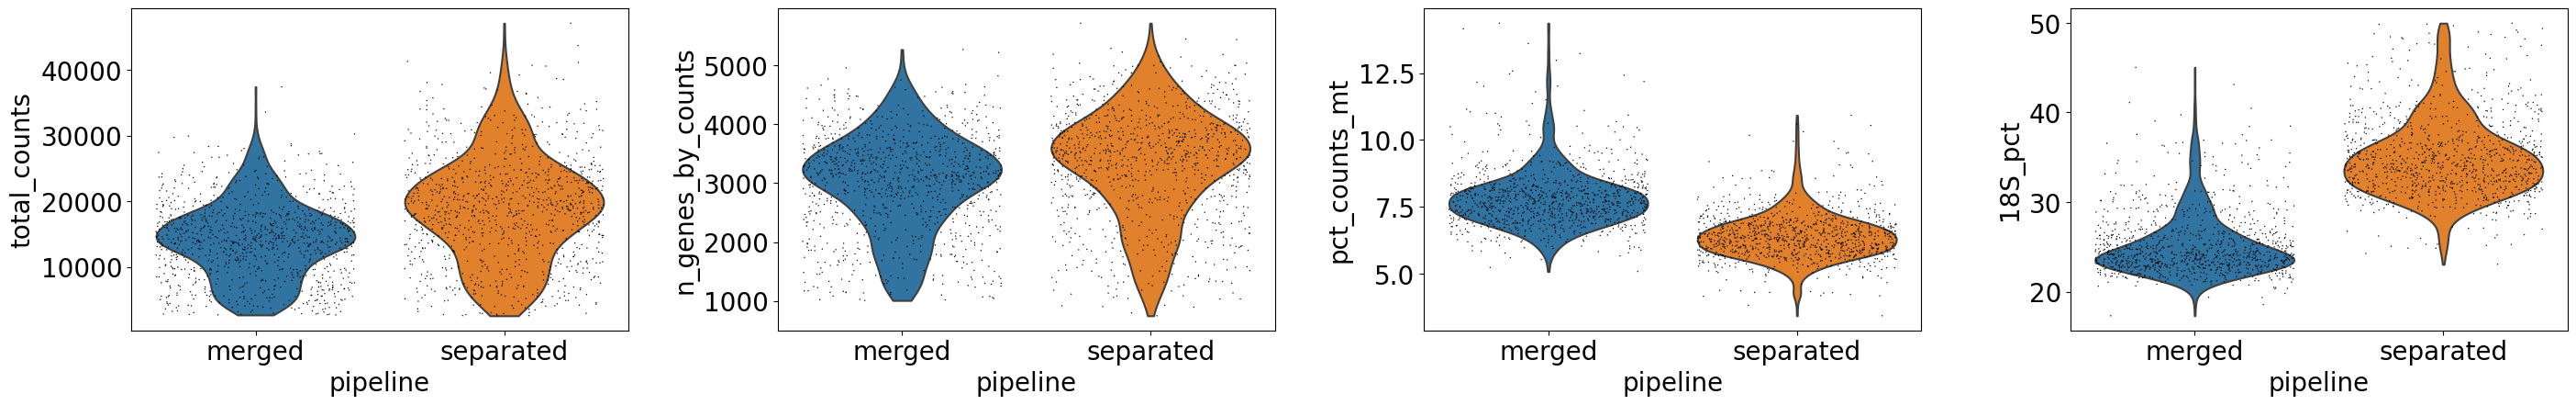

D:\Users\johannes.wirth\Anaconda3\envs\spatial\lib\site-packages\pandas\core\arrays\categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


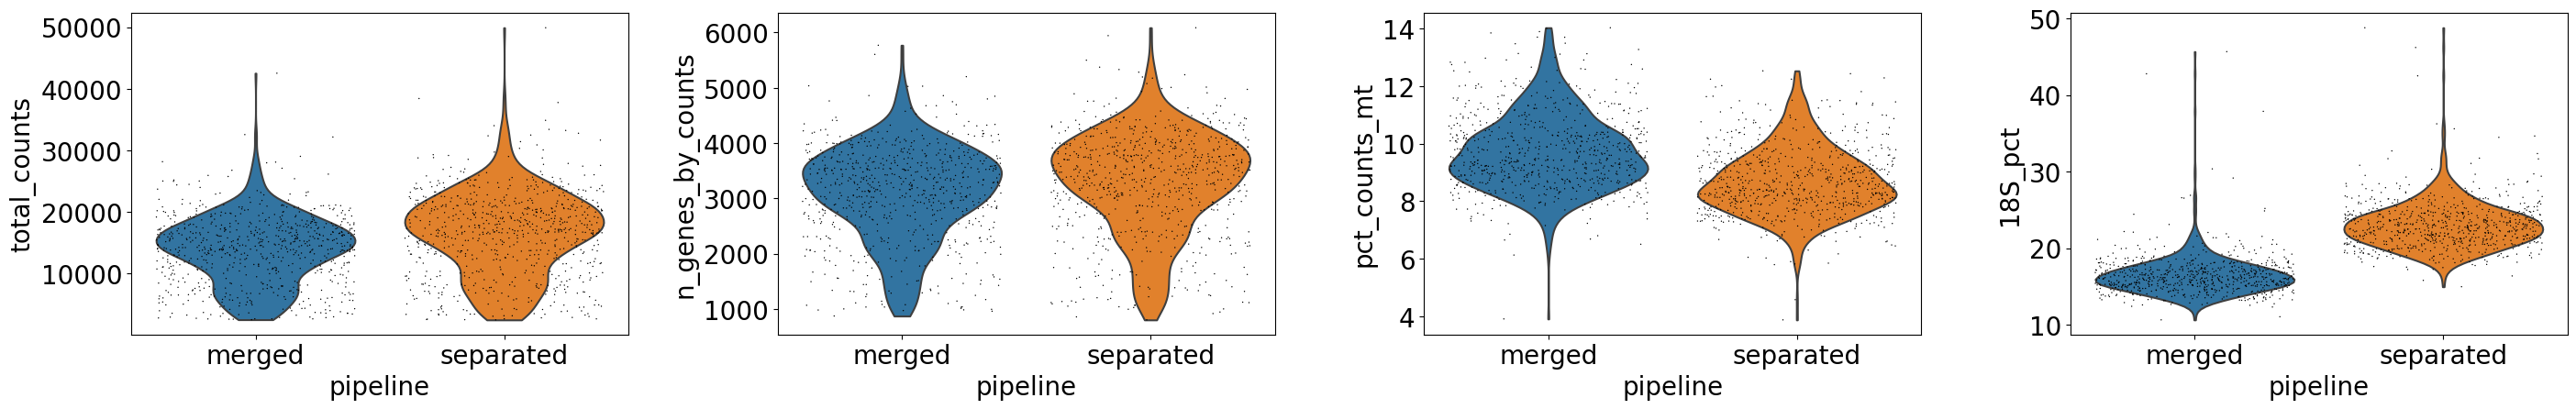

D:\Users\johannes.wirth\Anaconda3\envs\spatial\lib\site-packages\pandas\core\arrays\categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


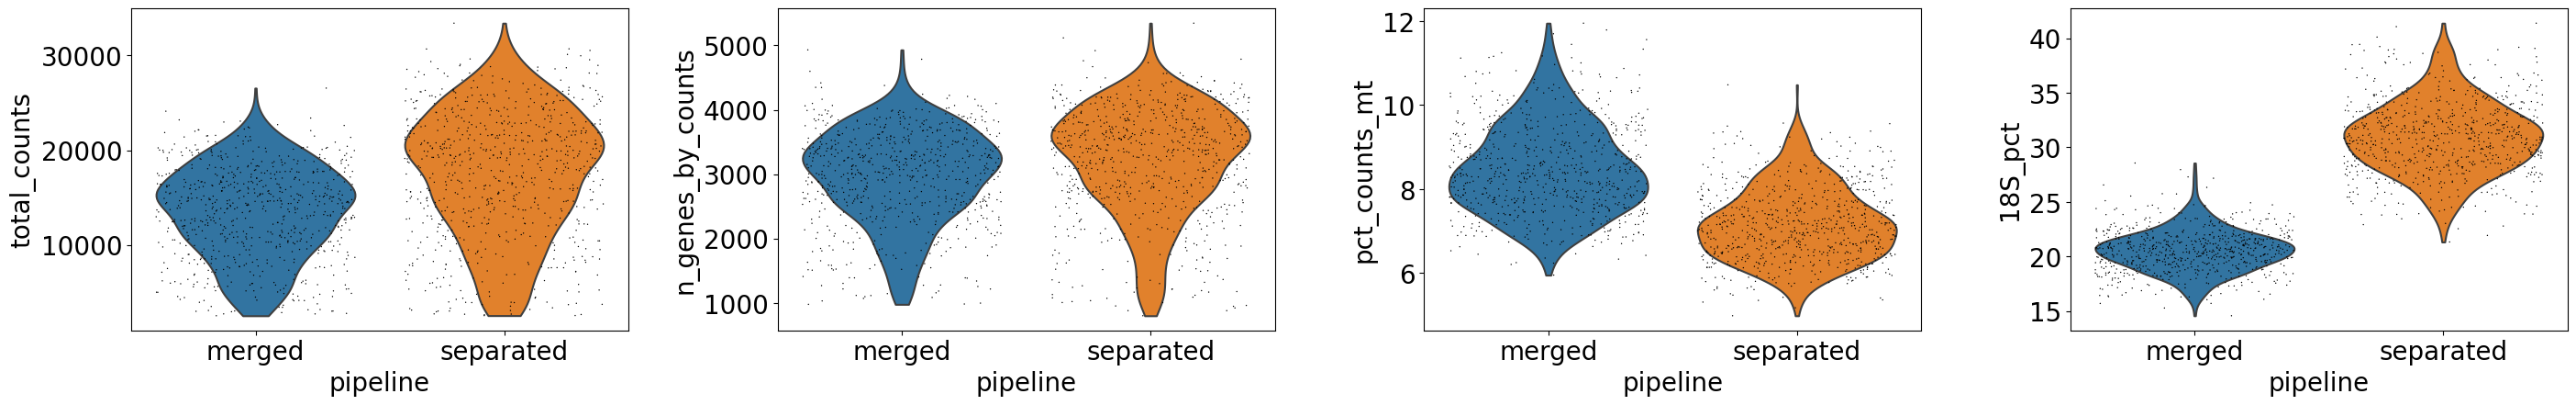

In [183]:
with plt.rc_context({'font.size': 20}):
    for w in adata.obs.well.unique():
        sc.pl.violin(adata[adata.obs.well == w, :], ['total_counts', 'n_genes_by_counts', 'pct_counts_mt', '18S_pct'], 
                     jitter=0.4, multi_panel=True, groupby='pipeline')

In [157]:
adata.obs.groupby('pipeline').mean()

array_row  array_col       um_row       um_col  n_genes_by_counts  \
pipeline                                                                       
merged     19.229818  18.571790  1922.981829  1857.179029        2928.768245   
separated  19.386892  19.607069  1938.689249  1960.706922        3160.618851   

           total_counts  total_counts_mt  pct_counts_mt    18S_pct  \
pipeline                                                             
merged     13101.255859      1072.130127       8.071270  22.174372   
separated  16738.974609      1167.893433       6.911239  30.977781   

               n_counts  
pipeline                 
merged     13091.408203  
separated  16724.017578

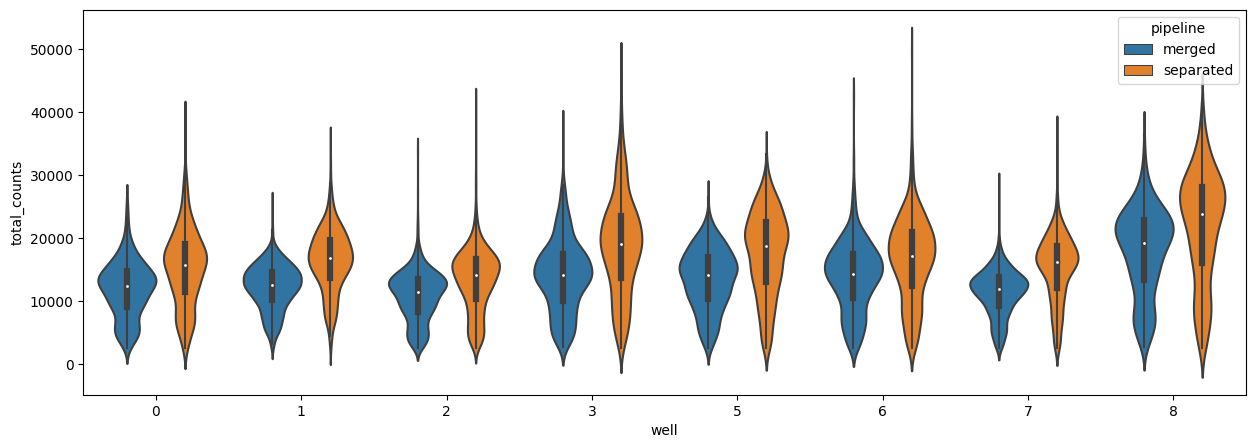

In [324]:
fig, axs = plt.subplots(1,1, figsize=(15,5))
sns.violinplot(x='well', y='total_counts', hue='pipeline', data=adata.obs, ax=axs)
plt.savefig("figures/counts_violin_mergedVSseparated.png")
plt.show()

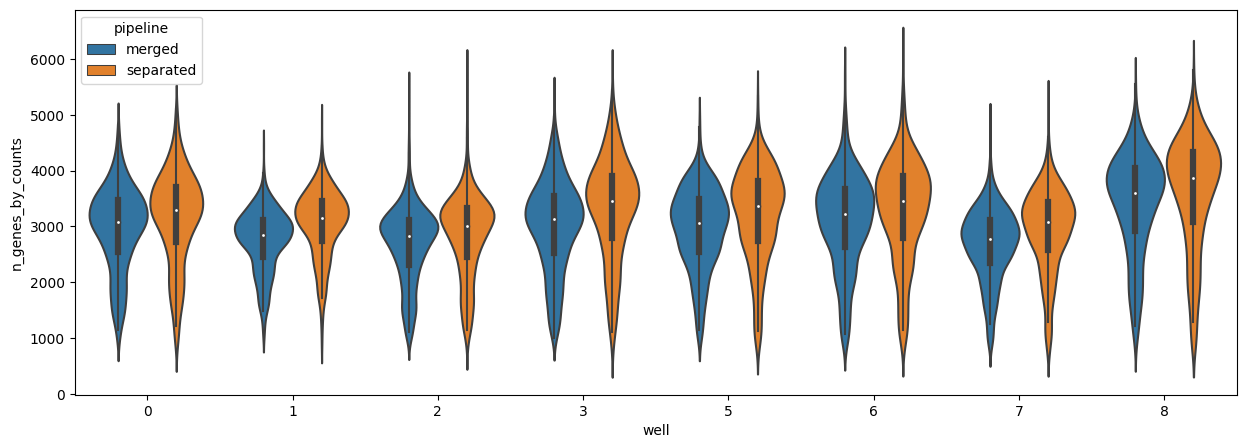

In [326]:
fig, axs = plt.subplots(1,1, figsize=(15,5))
sns.violinplot(x='well', y='n_genes_by_counts', hue='pipeline', data=adata.obs, ax=axs)
plt.savefig("figures/genes_violin_mergedVSseparated.png")
plt.show()

#### Plot relative increase

In [327]:
grouped = adata.obs.groupby(['well', 'pipeline']).mean()

In [328]:
relative_counts = [grouped.loc[(w, 'separated')]['total_counts'] / grouped.loc[(w, 'merged')]['total_counts'] for w in grouped.index.get_level_values('well').categories]
relative_genes = [grouped.loc[(w, 'separated')]['n_genes_by_counts'] / grouped.loc[(w, 'merged')]['n_genes_by_counts'] for w in grouped.index.get_level_values('well').categories]

In [329]:
df_relative = pd.DataFrame({
    'well': grouped.index.get_level_values('well').categories,
    'relative_counts': relative_counts,
    'relative_genes': relative_genes
})

In [330]:
df_relative['perc_increase_counts'] = (df_relative['relative_counts'] - 1) * 100
df_relative['perc_increase_genes'] = (df_relative['relative_genes'] - 1) * 100

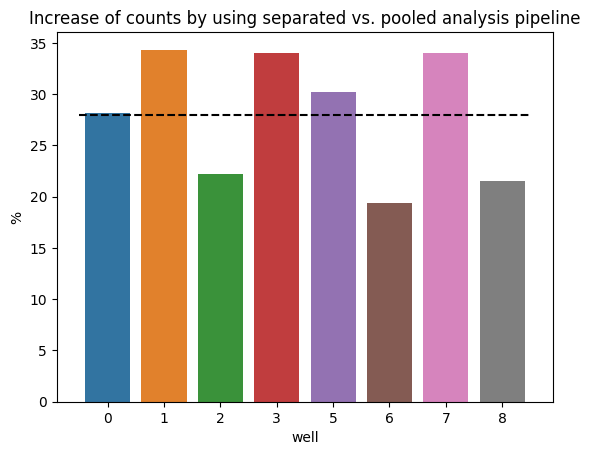

In [332]:
sns.barplot(x='well', y='perc_increase_counts', data=df_relative)
plt.title('Increase of counts by using separated vs. pooled analysis pipeline')
plt.hlines(df_relative['perc_increase_counts'].mean(), -0.5, 7.5, linestyles='dashed', colors='k')
plt.ylabel('%')
plt.savefig("figures/counts_perc_increase.png")

plt.show()

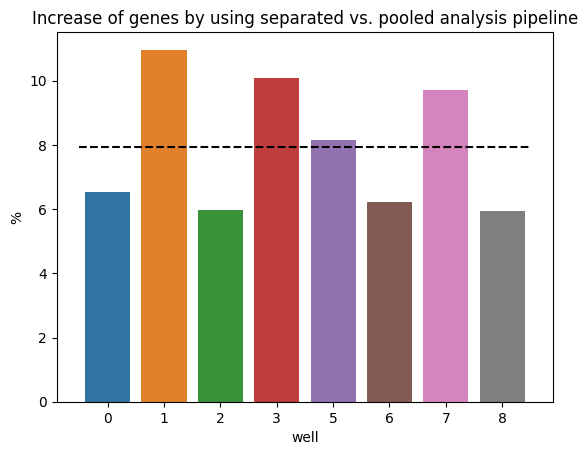

In [333]:
sns.barplot(x='well', y='perc_increase_genes', data=df_relative)
plt.title('Increase of genes by using separated vs. pooled analysis pipeline')
plt.hlines(df_relative['perc_increase_genes'].mean(), -0.5, 7.5, linestyles='dashed', colors='k')
plt.ylabel('%')
plt.savefig("figures/genes_perc_increase.png")

plt.show()